In [1]:
# Description: Plot Figure 6 (Parameter sweep [in Lj/Ld1-h0 space] for the monochromatic 2D topography experiments).
# Author:      André Palóczy
# E-mail:      paloczy@gmail.com
# Date:        March/2022

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from glob import glob
from cmocean.cm import balance, amp

In [3]:
def nancorr(x, y):
    fg = np.logical_and(np.isfinite(x), np.isfinite(y))
    return np.corrcoef(x[fg], y[fg])[0][1]

In [4]:
plt.close("all")

head = "../../simulations/"
facm1, fachf = 1e4, 1e3
m1min, m1max, m1cmap = -8, 8, balance
hfmin, hfmax, hfcmap = 0, 12, amp
m1onhfmin, m1onhfmax, m1onhfcmap = 0, 1, amp
sigmin, sigmax, sigcmap = 0.6, 2.3, amp
kermin, kermax, kerscmap = 0, 5, amp

method = "linear"
GRID = True
ttyp = "cosi"
N = 256
kt = 10
allF1s = np.array([25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325, 350, 375, 400])
allhts = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

F1s, hts, mom1s, thicks, momthickratios, sigmas, keratios = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])

In [5]:
for F1 in allF1s:
    for ht in allhts:
        fdir = head + "lin_N%d_ht%d_F1%d_%s%d"%(N, ht, F1, ttyp, kt)
        fname = fdir + ".npz"
        d = np.load(fname)
        mom1 = d["mom1"]
        thick = d["thick"]
        momthickratio = mom1/thick
        sigma = d["sigma"]
        keratio = d["keratio"]
        #print(F1, ht, momthickratio, sigma, keratio)

        mom1s = np.append(mom1s, mom1)
        thicks = np.append(thicks, thick)
        momthickratios = np.append(momthickratios, momthickratio)
        sigmas = np.append(sigmas, sigma)
        keratios = np.append(keratios, keratio)
        F1s = np.append(F1s, F1)
        hts = np.append(hts, ht)

In [6]:
sigmas = np.sqrt(sigmas) # KE-based growth rate translated to velocity magnitude.
momthickratios = np.abs(momthickratios)

In [7]:
if GRID:
    dF1, dht = np.diff(allF1s)[0], np.diff(allhts)[0]
    # dF1, dht = 0.1, 30
    F1si = np.arange(F1s.min(), F1s.max()+dF1, dF1)
    htsi = np.arange(hts.min(), hts.max()+dht, dht)
    F1si, htsi = np.meshgrid(F1si, htsi)
    x, y = F1s, hts
    xi, yi = F1si, htsi
    xy = (x, y)
    xyi = (xi, yi)
    momflx1s = griddata(xy, mom1s, xyi, method=method)
    thickflxs = griddata(xy, thicks, xyi, method=method)
    mtrs = griddata(xy, momthickratios, xyi, method=method)
    sigs = griddata(xy, sigmas, xyi, method=method)
    kers = griddata(xy, keratios, xyi, method=method)
else:
    xi, yi = np.meshgrid(F1s, hts)
    momflx1s = mom1s
    thickflxs = thicks
    mtrs = momthickratios
    sigs = sigmas
    kers = keratios

x = np.sqrt(x)/5
F1o = xi.copy()    # F1 = (5*Lj/Ld1)**2
xi = np.sqrt(xi)/5 # Lj/Ld1

In [8]:
# Big Lambda parameter.
delta = 1/4
F2o = F1o*delta
Lambda = F2o/yi # F2*U0/h0. h0 ~ bottom slope and U0 = 1 does not change.
Lambda[~np.isfinite(Lambda)] = np.nan

if False:
    figg, axx = plt.subplots()
    css = axx.scatter(sigs.ravel(), Lambda.ravel(), c=yi.ravel())
    figg.colorbar(css, label="$h_0$")
    axx.set_xlim((sigs.min(), sigs.max()))
    axx.set_ylim((np.nanmin(Lambda), np.nanmax(Lambda)))
    axx.set_xlabel("$\sigma$")
    axx.set_ylabel("$\Lambda$")

print(nancorr(sigs.ravel(), Lambda.ravel()))
a, b = sigs.ravel()[yi.ravel()>=5], Lambda.ravel()[yi.ravel()>=5]
print(nancorr(a, b))

0.5897769180735448
0.9338596024673875


/tmp/ipykernel_42748/2252748930.py:4: RuntimeWarning: divide by zero encountered in true_divide
  Lambda = F2o/yi # F2*U0/h0. h0 ~ bottom slope and U0 = 1 does not change.


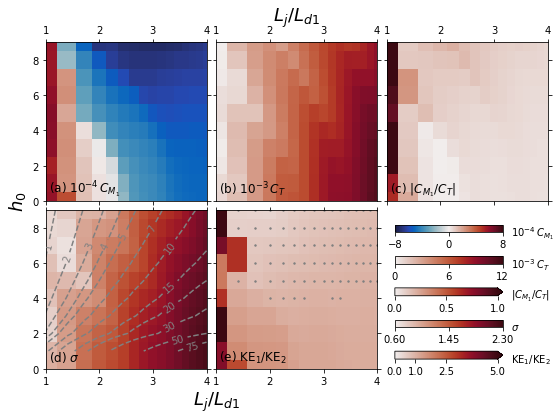

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
ax1, ax2, ax3 = ax[0]
ax4, ax5, ax6 = ax[1]
ax6.set_visible(False)
axsaux = (ax1, ax2, ax3, ax4, ax5)

kwcsm1 = dict(vmin=m1min, vmax=m1max, cmap=m1cmap)
kwcshf = dict(vmin=hfmin, vmax=hfmax, cmap=hfcmap)
kwcsm1onhf = dict(vmin=m1onhfmin, vmax=m1onhfmax, cmap=m1onhfcmap)
kwcssig = dict(vmin=sigmin, vmax=sigmax, cmap=sigcmap)
kwcskers = dict(vmin=kermin, vmax=kermax, cmap=kerscmap)
cs1 = ax1.pcolormesh(xi, yi, momflx1s*facm1, **kwcsm1)
cs2 = ax2.pcolormesh(xi, yi, thickflxs*fachf, **kwcshf)
cs3 = ax3.pcolormesh(xi, yi, mtrs, **kwcsm1onhf)
cs4 = ax4.pcolormesh(xi, yi, sigs, **kwcssig)
cs5 = ax5.pcolormesh(xi, yi, kers, **kwcskers)
fm1 = kers<1
ax5.scatter(xi[fm1], yi[fm1], s=2, c="gray")

Lamlevels = [1, 2, 3, 4, 5, 7, 10, 15, 20, 30, 50, 75]
cc = ax4.contour(xi, yi, Lambda, colors="gray", linestyles="dashed", levels=Lamlevels)
ax4.clabel(cc, fontsize=10, inline_spacing=2)

allLjonLd1s = np.sqrt(allF1s)/5
for axaux in axsaux:
    axaux.tick_params(bottom=True, top=True, left=True, right=True, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    axaux.set_xlim(allLjonLd1s[0], allLjonLd1s[-1])
    axaux.set_ylim(allhts[0], allhts[-1])

fig.subplots_adjust(wspace=0.06, hspace=0.06)
ax2.xaxis.set_ticks_position("top"); ax2.xaxis.set_label_position("top")
ax1.tick_params(labeltop=True, labelleft=True)
ax2.tick_params(labeltop=True, labelleft=False)
ax3.tick_params(labeltop=True, labelleft=False)
ax4.tick_params(labelleft=True, labelbottom=True)
ax5.tick_params(labelleft=False, labelbottom=True)
ax2.set_xlabel(r"$L_j/L_{d1}$", fontsize=18, fontweight="black")
ax5.set_xlabel(r"$L_j/L_{d1}$", fontsize=18, fontweight="black", x=0)
ax1.set_ylabel(r"$h_0$", fontsize=18, fontweight="black", y=0)

facm1str, fachfstr = ("%e"%facm1)[-1], ("%e"%fachf)[-1]
cbls = (r"$10^{-%s}\,C_{M_1}$"%facm1str, r"$10^{-%s}\,C_T$"%fachfstr, r"$|C_{M_1}/C_T|$", r"$\sigma$", r"$\mathrm{KE}_1/\mathrm{KE}_2$")

xt, yt = 0.02, 0.05
kwtxt = dict(color="k", fontsize=12, fontweight="normal")
ax1.text(xt, yt, r"(a) %s"%cbls[0], transform=ax1.transAxes, **kwtxt)
ax2.text(xt, yt, r"(b) %s"%cbls[1], transform=ax2.transAxes, **kwtxt)
ax3.text(xt, yt, r"(c) %s"%cbls[2], transform=ax3.transAxes, **kwtxt)
ax4.text(xt, yt, r"(d) %s"%cbls[3], transform=ax4.transAxes, **kwtxt)
ax5.text(xt, yt, r"(e) %s"%cbls[4], transform=ax5.transAxes, **kwtxt)

cbw = 0.67
kwcb = dict(fontsize=18, fontweight="normal")
caxx, caxy0 = 0.05, -0.2
cblx, cbly = cbw+0.1, -0.2
caxy1, caxy2, caxy3, caxy4, caxy5 = caxy0, caxy0*2, caxy0*3, caxy0*4, caxy0*5

_ = [ax3.text(cblx, cbly*n, cbl, va="center", transform=ax3.transAxes) for n, cbl in zip(range(1, 6), cbls)]

cb = fig.colorbar(mappable=cs1, cax=ax3.inset_axes([caxx, caxy1, cbw, 0.05]), orientation="horizontal")
cb.ax.xaxis.set_ticks_position("bottom"); cb.ax.xaxis.set_label_position("bottom")
cb.set_ticks([m1min, 0, m1max])

cb = fig.colorbar(mappable=cs2, cax=ax3.inset_axes([caxx, caxy2, cbw, 0.05]), orientation="horizontal")
cb.ax.xaxis.set_ticks_position("bottom"); cb.ax.xaxis.set_label_position("bottom")
cb.set_ticks([hfmin, (hfmax+hfmin)/2, hfmax])

cb = fig.colorbar(mappable=cs3, cax=ax3.inset_axes([caxx, caxy3, cbw, 0.05]), orientation="horizontal", extend="max")
cb.ax.xaxis.set_ticks_position("bottom"); cb.ax.xaxis.set_label_position("bottom")
cb.set_ticks([m1onhfmin, (m1onhfmax+m1onhfmin)/2, m1onhfmax])

cb = fig.colorbar(mappable=cs4, cax=ax3.inset_axes([caxx, caxy4, cbw, 0.05]), orientation="horizontal")
cb.ax.xaxis.set_ticks_position("bottom"); cb.ax.xaxis.set_label_position("bottom")
cb.set_ticks([sigmin, (sigmax+sigmin)/2, sigmax])

cb = fig.colorbar(mappable=cs5, cax=ax3.inset_axes([caxx, caxy5, cbw, 0.05]), orientation="horizontal", extend="max")
cb.ax.xaxis.set_ticks_position("bottom"); cb.ax.xaxis.set_label_position("bottom")
cb.set_ticks([kermin, 1, (kermax+kermin)/2, kermax])

fig.savefig("fig06.png", bbox_inches="tight")

plt.show()